In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import os
import cv2
from PIL import Image
import dill
from tensorflow.keras.layers import *

In [6]:
def train_data_gen(batch_size=32):
    train=[os.path.join('dataset/train',e) for e in os.listdir('dataset/train')]
    test=[os.path.join('dataset/test',e) for e in os.listdir('dataset/test')] 
    files=train+test 
    while True : 
        np.random.shuffle(files) 
        X=[] 
        Y=[]
        for i in range(batch_size):
            img=np.array(Image.open(files[0]).convert('L').resize((512,512)))/255
            X+=[img] 
        X=np.expand_dims(np.array(X),axis=-1)
        Y=X.copy() 
        yield X,Y

In [7]:
data_gen=train_data_gen(2)

In [8]:
X,Y=next(data_gen)

**AutoEncoder Model**

In [9]:
class Denoise(tf.keras.models.Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            Input(shape=(512,512, 1)),
            Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
            Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
            Conv2D(256, (3, 3), activation='relu', padding='same', strides=2),
            Conv2D(512, (3, 3), activation='relu', padding='same', strides=2),
            Conv2D(1024, (3, 3), activation='relu', padding='same', strides=2),
            #GlobalAveragePooling2D()
        ])
        

        self.decoder = tf.keras.Sequential([
            Conv2DTranspose(1024, kernel_size=3, strides=2, activation='relu', padding='same'),
            Conv2DTranspose(512, kernel_size=3, strides=2, activation='relu', padding='same'),
            Conv2DTranspose(256, kernel_size=3, strides=2, activation='relu', padding='same'),
            Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
            Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
            Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
            Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        t= self.encoder(x)
        #t=tf.expand_dims(tf.expand_dims(t,axis=1),axis=1)
        #t=tf.concat([t]*4,axis=1)
        #t=tf.concat([t]*4,axis=2)
        
        decoded = self.decoder(t)
        return decoded

In [16]:
# model.load_weights('auto_encoder.h5')

In [12]:
model=Denoise()

In [37]:
optimizer=tf.keras.optimizers.Adam(0.0001) 
data_gen=train_data_gen(5)

In [38]:
model.compile(optimizer=optimizer,loss='mse',metrics=['mse'])

In [68]:
model.fit(data_gen,epochs=1000,batch_size=10)

Epoch 1/1000
   4603/Unknown - 4969s 1s/step - loss: 0.0135 - mse: 0.0135

KeyboardInterrupt: 

In [69]:
model.save_weights('auto_encoder.h5')

**Images to Vectors**

In [70]:
X=[] 
Y=[]
train_images=[os.path.join('dataset/train',e) for e in os.listdir('dataset/train')] 
for image in train_images :
    img=np.array(Image.open(image).convert('L').resize((512,512)))/255
    X+=[np.expand_dims(img,axis=-1)]
    Y+=[image.split('/')[-1].split('.')[0]] 
X=np.array(X) 
X=Flatten()(model.encoder(X) )
X=np.array(X)
df=pd.DataFrame(X,index=Y)

In [71]:
df.to_csv('df_train.csv')

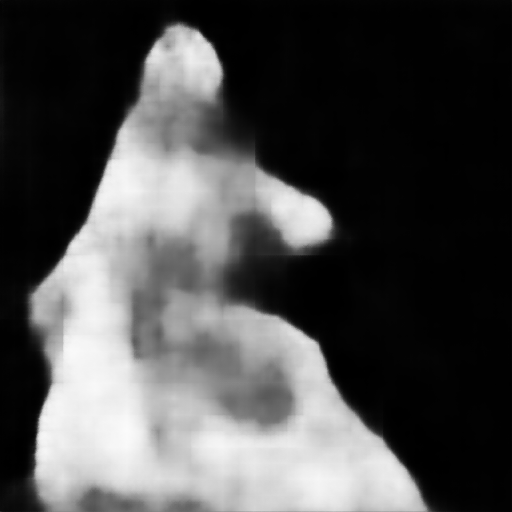

In [75]:
Image.fromarray( (255*(np.array(model(next(data_gen)[0])) )[0,:,:,0]).astype('uint8'))